<a href="https://colab.research.google.com/github/weymouth/MarineHydro/blob/master/notebooks/panel_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Potential flow panel method 🚢

A panel method is a numerical approach to constructing potential flows around engineering shapes such as a wing or ship hull. Panel methods used in industry are typically 3D, but we will use a 2D approach which is sufficient for strip theory calculations.

## Potential and velocity of a source panel 🚰

The 2D vesion of a panel is a line _segment_. In general this segment will run from some point $(x_i,y_i)$ to $(x_{i+1},y_{i+1})$ and will have a potential flow singularity distributed over it. 

For example, a 2D source potential is proportional to

$$ G(x,y,x_s,y_x) = \log(r_s) = \frac 12 \log(r_s^2) $$

where $r_s^2 = (x-x_s)^2+(y-y_s)^2$ is the square-distance from the point $(x_s,y_s)$ on the segment to a point $(x,y)$ in space. $G$ is called a [Green's function](https://en.wikipedia.org/wiki/Green%27s_function) and you can think of it as the building block for the panel method. 

The potential of the panel is the integrated superposition of $G$ along the segment, ie

$$ \phi_i(x,y) = q_i \int_{s_i}^{s_{i+1}} G(x,y,x_s,y_s) ds = q_i F_i^\phi(x,y)$$

where $q_i$ is the source strength per segment length. We will assume the strength is constant along each panel, allowing us to pull it out of the integral. The function $F_i^\phi$ is the potential **influence function**, the potential induced by segment $i$ per unit strength.

The potential flow velocity is the gradient of this potential (as usual) and since the $q_i$ is a constant, we can pull it outside the derivative

$$ \vec u_i = \vec\nabla\phi_i = q_i\vec\nabla F^\phi_i=q_iF^{\vec u}_i\ ,\quad F^{\vec u}_i = \left[\frac{\partial F^\phi_i}{\partial x},\frac{\partial F^\phi_i}{\partial y}\right]$$

which defines the influence functions for the velocity $\vec u$. __Let's implement these equations numerically.__

In [1]:
import numpy as np

def source(x,y,xs,ys): return 0.5*np.log((x-xs)**2+(y-ys)**2)

GAUSS2 = 0.5*(1+np.sqrt(1/3)) # gaussian-quadrature sample point
def potential(x,y,x0,y0,x1,y1,G=source,args=()):
  "Gaussian quadrature estimate of the potential influence function"
  def dG(s): return G(x,y,x0*(1-s)+x1*s,y0*(1-s)+y1*s,*args)
  h = np.sqrt((x1-x0)**2+(y1-y0)**2)
  return 0.5*h*(dG(GAUSS2)+dG(1-GAUSS2))

def velocity(x,y,x0,y0,x1,y1,G=source,args=(),eps=1e-6):
  "Finite difference estimate of the velocity influence function"
  def phi(x,y): return potential(x,y,x0,y0,x1,y1,G,args)
  return np.array(((phi(x+eps,y)-phi(x-eps,y))/(2*eps),  # dphi/dx
                   (phi(x,y+eps)-phi(x,y-eps))/(2*eps))) # dphi/dy

There are three functions:
1. `source` defines the source Green's function $G$,
2. `potential` estimates the influence function $F^\phi$ using a [Gaussian-quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature#/media/File:Comparison_Gaussquad_trapezoidal.svg), and
3. `velocity` estimates the influence function $F^{\vec u}$ using [finite differences](https://en.wikipedia.org/wiki/Finite_difference#/media/File:Finite_difference_method.svg).

> **Note:** An approximate method for an integral, such as the trapezoidal rule $\int_0^h f ds \approx \frac 12 h [f(0)+f(h)]$, is called a _quadrature_. A 2-point Gaussian-quadrature is just as simple as the trapezoidal method, but is _much_ more accurate because it samples the function a bit inward from the boundaries.

Let's test these functions by plotting the flow induced by a single panel on a background grid of points.

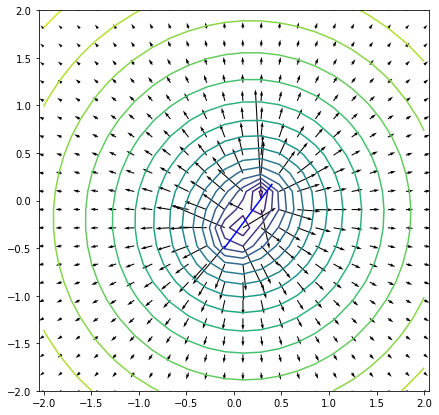

In [2]:
from matplotlib import pyplot as plt

# Example segment
x0,y0 = -.1,-0.5
x1,y1 = 0.4,.17

# Visualize the flow
XY = np.meshgrid(np.linspace(-2,2,22),np.linspace(-2,2,22))
UV = velocity(*XY, x0, y0, x1, y1)
Phi = potential(*XY, x0, y0, x1, y1) 

# Plot it up
plt.figure(figsize=(7,7))
plt.quiver(*XY, *UV)
plt.contour(*XY, Phi, 20)
plt.plot([x0,x1],[y0,y1],c='b')
plt.axis('equal');

Looks good! The resulting flow is the same as a point-source flow when $r \gg ds$, _which makes physical sense_. However, the velocity is finite and smooth near the panel. This "well behaved" velocity makes panels a better choice for numerical methods than point-singularities.

> **Note:** Using numerical approximations makes our `potential` and `velocity` functions **re-usable**. We have used a source singularity, but we could use some other Green's function if we want. _Different singularities are good for building different types of flows_. [This interactive webapp](https://weymouth.github.io/fluid-dynamics/vortexpanel/index.html) uses vortex segments to predict the flow and forces over a thin wing, and the next notebook we will use a wave singularity for free surface flows.

---

## Superposition 💧➕💧➕💧= 💦

The next step is to link multiple panels together to form a geometry. The total potential and velocity is simply the superposition (sum) of the contribution from each panel

$$\phi=\sum_i \phi_i=\sum_i q_i F_i^\phi\ ,\quad \vec u = \sum_i \vec u_i=\sum_i q_i F_i^{\vec u}.$$ 

Let's define a set of $N$ panels by connecting $N+1$ points $x_0\ldots x_N$ and $y_0\ldots y_N$. Then the Python code for the potential or velocity is a simply `sum` over `i in range(N)`. 

Here's a superposition version of the plotting code above, and a test on a few panels.

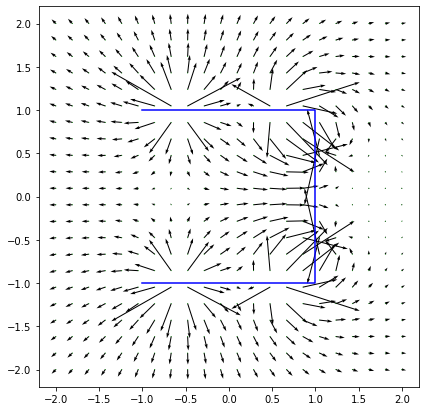

In [3]:
def plot_flow(x,y,q,XY,G=source,args=(),size=(7,7),ymax=None):
  "Plot the geometry and induced velocity field"

  # Loop through segments, superimposing the velocity
  def uv(i): return q[i]*velocity(*XY, x[i], y[i], x[i+1], y[i+1], G, args)
  UV = sum(uv(i) for i in range(len(x)-1))
  UV /= np.linalg.norm(UV) # normalize

  # Create plot
  plt.figure(figsize=size)
  ax=plt.axes(); ax.set_aspect('equal', adjustable='box')

  # Plot vectors and segments
  plt.quiver(*XY, *np.real(UV), scale = 1)
  plt.quiver(*XY, *np.imag(UV), scale = 1, color='g')
  plt.plot(x,y,c='b')
  plt.ylim(None,ymax)

plot_flow([-1,1,1,-1],[-1,-1,1,1],[1,-1,1],XY)

Excellent! We can now plot the flow induced by a set of panels. Move around the points and change the strength `q` to see how the flow changes.

> **Note:** The velocity isn't _that_ smooth since we've only approximated the integral with two samples (you can see where they are). This will be less of a problem when we use smaller panels. Lets define a function to create `N` panels in the shape of an ellipse.

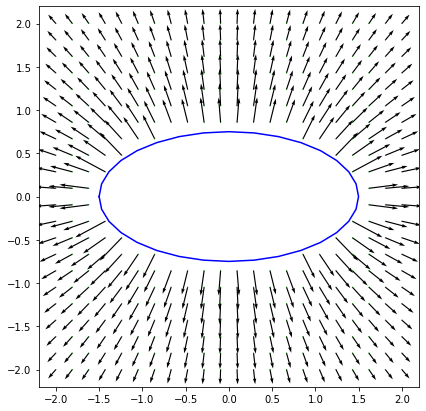

In [3]:
def ellipse(N,a=1,b=1,theta1=np.pi):
  "x,y arrays around an elliptical arc"
  theta = np.linspace(-np.pi,theta1,N+1) # N+1 points for N panels
  return a*np.cos(theta),b*np.sin(theta)

def mask_grid(x,y,mask):
  "delete mesh points where mask is true"
  return np.array((x[~mask(x,y)],y[~mask(x,y)]))

# geometry
N,rx,ry = 32,1.5,0.75
x,y = ellipse(N,rx,ry)
EXY = mask_grid(*XY,mask=lambda x,y: (x/rx)**2+(y/ry)**2<1)

q = np.ones_like(x) # we don't know q yet!
plot_flow(x,y,q,EXY)



## Linear system 🚣 ✖ ⚡ = 🚤

The figure above assumes $q_i=1$, but we can get different flows around the same geometry by adjusting this strength. But how can we set $q_i$ to, say, compute the flow over an ellipse moving to the left?

The Laplace equation $\nabla^2 \phi = 0$ is satisfied automatically for any set of panel strengths so we need to determine $q_i$ another way. 

Instead the strength is determined using the normal velocity body boundary condition
$$\sum_i \vec u_i\cdot \hat n = \vec U \cdot \hat n \quad\text{on the body}$$ 
where $\hat n$ is the body normal and $\vec U$ is the body velocity. 

Substituting the equation for $\vec u_i$ and applying this on every panel $j$ we have

$$\sum_i q_i F^{\vec u}_i(\vec c_j)\cdot \hat n_j = \vec U \cdot \hat n_j$$

where $\vec c_j$ and $\hat n_j$ are the center and normal of panel $j$.  

Defining $a_{ij}=F^{\vec u}_i(\vec c_j)\cdot \hat n_j$ as the normal velocity influence of panel $i$ on panel $j$ and the right-hand-side as $b_j=\vec U \cdot \hat n_j$, we have 

$$\sum_i a_{ij}q_i=b_j$$

This is a linear system of equations which we can write in the familiar matrix form $\mathbf{A q=b}$. Since both $i,j$ run over `range(N)` we have $N$ equations and $N$ unknowns and we can solve for $q_i$ using NumPy's linear algebra function [`numpy.linalg.solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

> **Note:** The velocity induced by a souce panel on itself isn't accounted for using the `velocity` function, so I've added this contribution to the diagonal of $\mathbf{A}$ using the identity matrix function [np.eye](https://numpy.org/devdocs/reference/generated/numpy.eye.html).

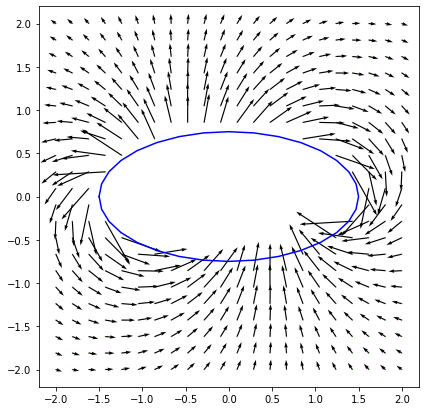

In [4]:
def properties(x0, y0, x1, y1):
  "properties of a line segment"
  sx, sy = x1-x0, y1-y0         # segment vector
  xc, yc = x0+0.5*sx, y0+0.5*sy # segment center 
  h = np.sqrt(sx**2+sy**2)      # segment length
  nx, ny = sy/h, -sx/h          # segment unit normal
  return xc, yc, nx, ny, h

def construct_A(x,y,G=source,args=()):
  "construct the velocity influence matrix"
  # influence of panel i on the normal velocity at each panel center
  xc, yc, nx, ny, _ = properties(x[:-1], y[:-1], x[1:], y[1:])
  def u_n(i):
    u,v = velocity(xc,yc,x[i],y[i],x[i+1],y[i+1],G,args)
    return u*nx+v*ny

  # construct matrix
  A = np.array([u_n(i) for i in range(len(yc))]).T
  A += np.pi*np.eye(len(yc)) # add panel self-influence
  return A,nx,ny

Ux,Uy = -1,1 # set motion direction
A,nx,ny = construct_A(x,y)
q = np.linalg.solve(A,Ux*nx+Uy*ny)
plot_flow(x,y,q,EXY)

Awesome! We can now solve for the potential flow around any set of moving panels!! **But is this flow correct?!?**

> **Note:** We should never trust a numerical solution until we have tested the solver. 

At the very least, we insist that the solution $q$ **converges** as we increase the number of panels. This is easy to check:

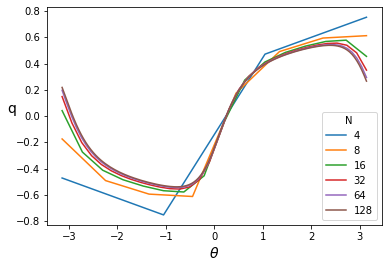

In [5]:
for N in 2**(np.arange(6)+2):
  x,y = ellipse(N,rx,ry)
  A,nx,ny = construct_A(x,y)
  q = np.linalg.solve(A,Ux*nx+Uy*ny)
  plt.plot(np.linspace(-np.pi,np.pi,N),q,label=N)
plt.xlabel(r'$\theta$',size=14);plt.ylabel('q',rotation=0,size=14)
plt.legend(title='N');

We can see the solution does converge with $N$ and the difference between using 64 and 128 panels is extremely small. 

---

## Added mass 🐙

One of the most important applications of potential flow is the estimation of added mass forces due to body acceleration. There are two steps to predicting the added mass: 

**1. Determine the potential for unsteady motion in direction $k$**

We define the *unsteady* potential as
$$\phi(\vec x,t) = \sum_k U_k(t) \ \phi_k(\vec x)$$
where $U_k$, $\phi_k$ are the unsteady velocity and the resulting *scaled potential* for motion in direction $k$ ($\hat x = \hat e_1$ and $\hat y = \hat e_2$) .

> **Note:** This is a separation of variables trick since $U_k$ depends only on time and $\phi_k$ depends only on space. This simplifies integrals or derivatives in time or space. For example, $$u_n = \frac{\partial\phi}{\partial n} = \frac{\partial}{\partial n}\left(\sum_k U_k\phi_k\right) = \sum_k U_k\frac{\partial \phi_k}{\partial n}.$$

Substituting the potential into the *unsteady* condition $u_n = \sum_k U_k n_k$ on the body, and dividing both sides by $U_k$ gives

$$\frac{\partial \phi_k}{\partial n}=n_k$$

which is essentially the *steady* normal-velocity body boundary condition treated above. So the scaled source strength of each panel is determined by
$$ \mathbf{A}\mathbf{q}_k = \mathbf{n}_k$$
and the scaled potential is the superposition $\phi_k(\vec x) = \sum_i q_{k,i} F_i^\phi(\vec x)$.

**2. Integrate the pressure to determine the force**

The added mass force is the body integral of the pressure due to the unsteady potential

$$ \vec f = \rho \oint \frac{\partial\phi}{\partial t} \hat n ds$$

Substituting $\frac{\partial\phi}{\partial t}=\sum_k\dot U_k \phi_k$ gives the $l$-component of the added mass force as

$$ f_l = -\sum_{k} \dot U_k m_{kl} \quad\text{where}\quad m_{kl} = -\rho\oint \phi_k n_l ds$$
where $\dot U_k$ is the body acceleration and $m_{kl}$ is the **added mass matrix**.

Approximating the integral as a sum over panels each with length $h_j$ and substituting the superposition for $\phi_k$ gives $m_{kl}$ as
$$ m_{kl} = -\rho\sum_j\sum_i h_j F_i^\phi(\vec c_j) q_{k,i} n_{l,j} $$

> **Note:** As before, these summations over the panels can be written as matrix multiplications `m_kl=(hF @ q_k) @ (n_l)`

That's it. *1.* Solve for each $q_k$ using $n_k$ as the right-hand-side, and *2.* plug it into the double summation. 

In [6]:
def added_mass(x,y,G=source,args=()):
  "Compute the added mass matrix (per rho)"
  # strength due to x,y motion
  A,n1,n2 = construct_A(x,y,G,args)
  q1 = np.linalg.solve(A,n1)
  q2 = np.linalg.solve(A,n2)

  # potential due to x,y motion (times panel width)
  xc,yc,_,_,h = properties(x[:-1], y[:-1], x[1:], y[1:])
  hF = [h*potential(xc,yc,x[i],y[i],x[i+1],y[i+1],G,args) for i in range(len(yc))]
  phi1,phi2 = hF@q1,hF@q2 # potential influence matrix times strength

  # sum over panels
  return -np.matrix([[phi1@n1,phi1@n2],[phi2@n1,phi2@n2]])

N,r1,r2 = 64,1.5,0.75
ma = added_mass(*ellipse(N,r1,r2))
print(np.array_str(ma, precision=3, suppress_small=True))

[[ 1.783 -0.   ]
 [-0.     7.053]]


The function above takes in the set of panels and returns the added mass matrix (scaled by $\rho$).

The first thing to do is to make sure the results are physically sensible:
 1. The off diagonal values are zero, meaning there is no force generated in $x$ when accelerating in $y$ and vice-versa. Can you see why this is always true for objects moving along their axis of symmetry?
 2. $m_{22}>m_{11}$ when $r_1>r_2$. Is it clear why moving perpendicular to the long axis will accelerate more fluid and produce more added mass?

The next thing to do is to **validate** our numerical method!

> **Note:** A numerical method is validated if the solution converges to a known exact solution. 

Newman gives the analytic the added mass of an ellipse with semi-axis lengths $r_1,r_2$ as $m_{11} = \rho \pi r_2^2,\ m_{22}=\rho\pi r_1^2$. Let's see if the code converges to these targets:

In [7]:
def err(est,true): return 100*(est-true)/true 
print('    |   % error\n N  |  m11 |  m22 ')
r1,r2 = 1.5,0.75
for N in 2**(np.arange(6)+4):
  m = added_mass(*ellipse(N,r1,r2))
  print(f'{N:3} | {err(m[0,0],np.pi*r2**2):.2f} | {err(m[1,1],np.pi*r1**2):.2f}')

    |   % error
 N  |  m11 |  m22 
 16 | 1.88 | -2.73
 32 | 1.48 | -0.74
 64 | 0.87 | -0.22
128 | 0.47 | -0.07
256 | 0.24 | -0.02
512 | 0.12 | -0.01


The error is less than 1% for the added mass coefficients using only 32-64 panels and converges to zero with more panels. The code is validated!

> **Note:** The error goes down by $\times 2$ when the number of panels increases by $\times 2$. Therefore the error is proportional to the panel size, $\varepsilon\sim h$, which is called _linear_ convergence. 

---

## Summary 🏁 🏁

That's it for this notebook. We covered a lot, so go back through and make sure you understand the key points:
 1. Panel methods are a numerical approach to compute the potential flow around an engineering geometry by breaking it up into small panels (or line segments in 2D).
 2. Each panel is an integrated Green's function (such as a source singularity) with a variable strength and the total flow is the superposition (sum) of each panel's contribution. 
 3. The strengths $q_i$ are determined by solving a system of linear equations for the normal velocity through every panel.
 4. Once the strengths are known, they can be used to plot the flow and determine the added mass.

Also remember that numerical methods should never be trusted until they have been properly validated. In this case:
 1. We checked that the potential and flow plots as well as the added mass values were all **physically reasonable**.
 2. We ensured that the source strength **converges** with increasing number of panels and
 3. We **validated** the code against the known analytic added mass values for a nontrivial (ellipse) geometry.